### Exploring HDBSCAN

With this notebook we explore the possibilities of HDBSCAN, the extended and allegedly
better performing brother of DBSCAN.

In [160]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import s2spy.time
import s2spy.rgdr
from s2spy import RGDR
import hdbscan
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd

First we will load in some example data, and resample them using `s2spy`'s `Calendar`.

In [76]:
file_path = '../tests/test_rgdr/test_data'
field = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target = xr.open_dataset(f'{file_path}/tf5_nc5_dendo_80d77.nc')

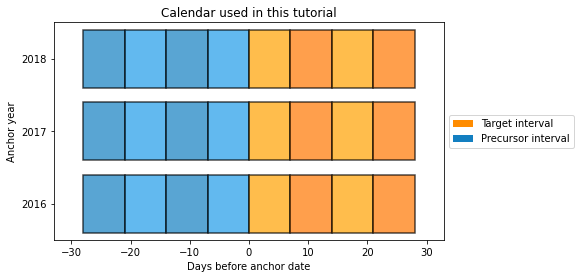

In [77]:
cal = s2spy.time.Calendar(anchor="08-01")
cal.add_intervals("target", length="1W", n=4)
cal.add_intervals("precursor", length="1W", n=4)

cal = cal.map_to_data(field)
cal.visualize(n_years=3, relative_dates=True)
_ = plt.title("Calendar used in this tutorial")

In [78]:
field_resampled: xr.Dataset = s2spy.time.resample(cal, field)
target_resampled: xr.Dataset = s2spy.time.resample(cal, target)

Text(0.5, 1.0, 'DBSCAN')

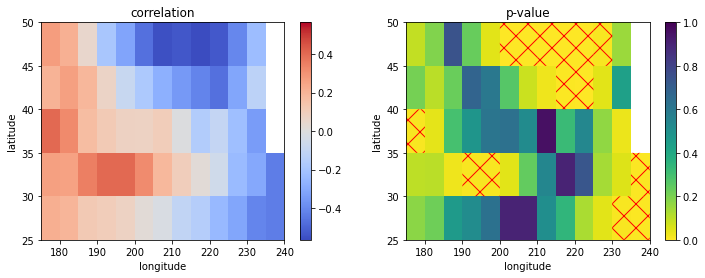

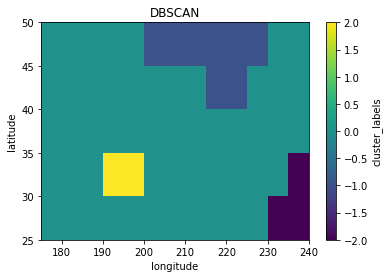

In [79]:
target_timeseries = target_resampled.sel(cluster=3)["ts"]
precursor_field = field_resampled["sst"]

target_intervals = 1
lag = 4
alpha = 0.01
eps_km = 600
min_area_km2 = 600**2

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
rgdr = RGDR(target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2)
_ = rgdr.preview_correlation(precursor_field, target_timeseries, ax1=ax1, ax2=ax2)

fig, ax = plt.subplots(figsize=(6, 4))
RGDR(
    target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2
    ).preview_clusters(precursor_field, target_timeseries, ax=ax, vmin=-2, vmax=2)
ax.set_title('DBSCAN')

### Explore hdbscan
Let's try to reproduce this result with HDBSCAN.

In [80]:
rgdr = RGDR(target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2)
corr, p_vals = rgdr.get_correlation(precursor_field, target_timeseries)
data = precursor_field.to_dataset()
data["corr"], data["p_val"] = corr, p_vals  # Will require less tracking of indices
data = data.stack(coord=["latitude", "longitude"])
coords = np.asarray(data["coord"].values.tolist())
coords = np.radians(coords)

In [81]:
labels = np.zeros(len(coords), dtype=int)
clusterers = []
for sign, sign_mask in zip([1, -1], [data["corr"] >= 0, data["corr"] < 0]):
    mask = np.logical_and(data["p_val"] < alpha, sign_mask)
    if np.sum(mask) > 0:  # Check if the mask contains any points to cluster
        clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='haversine')
        clusterers.append(clusterer)
        db = clusterer.fit(coords[mask]) #noisy samples are -1
        print(coords[mask])
        labels[mask] = sign * (db.labels_ + 1)
        print(db.labels_)
        print(labels)

[[0.65449847 3.09795942]
 [0.56723201 3.35975881]
 [0.56723201 3.44702527]]
[-1 -1 -1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0.82903139 3.53429174]
 [0.82903139 3.6215582 ]
 [0.82903139 3.70882466]
 [0.82903139 3.79609112]
 [0.82903139 3.88335759]
 [0.82903139 3.97062405]
 [0.74176493 3.79609112]
 [0.74176493 3.88335759]
 [0.56723201 4.14515697]
 [0.47996554 4.05789051]
 [0.47996554 4.14515697]]
[1 1 1 1 1 1 1 1 0 0 0]
[ 0  0  0  0  0 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0 -2 -2  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0 -1 -1]


plot DBSCAN (left) and HDBSCAN (right)

Text(0.5, 1.0, 'HDBSCAN')

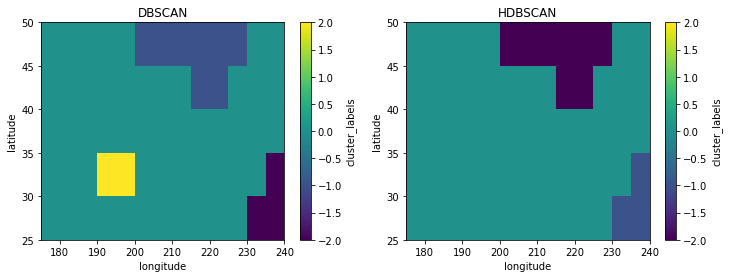

In [82]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

#HDBSCAN
precursor = precursor_field.stack(coord=["latitude", "longitude"])
precursor["cluster_labels"] = ("coord", labels)
precursor["cluster_labels"] = precursor["cluster_labels"].astype("int16")
precursor = precursor.unstack(("coord"))
precursor["cluster_labels"].plot(cmap="viridis", ax=ax2, vmin=-2, vmax=2)
#DBSCAN
RGDR(
    target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2
    ).preview_clusters(precursor_field, target_timeseries, ax=ax1, vmin=-2, vmax=2)

ax1.set_title('DBSCAN')
ax2.set_title('HDBSCAN')


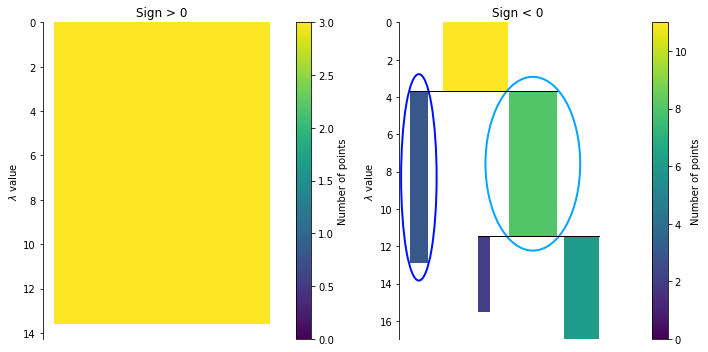

In [83]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
clusterers[0].condensed_tree_.plot(select_clusters=True,
                               selection_palette=plt.cm.jet(np.linspace(0, 1, 8))[1:-1], cmap='viridis', colorbar=True, axis=ax1)
clusterers[1].condensed_tree_.plot(select_clusters=True,
                               selection_palette=plt.cm.jet(np.linspace(0, 1, 8))[1:-1], cmap='viridis', colorbar=True, axis=ax2)
ax1.set_title('Sign > 0')
ax2.set_title('Sign < 0')
fig.tight_layout()

Not possible to get the same results with this test data set since HDBSCAN cannot estimate the pdf with only 3 points for the positive correlation.
Proceed with bigger dataset.

#### proceed with bigger dataset

First we will load in some data, and resample them using `s2spy`'s `Calendar`.

In [117]:
data_path = '../data'
testdata_path = '../tests/test_rgdr/test_data'
field = xr.open_dataset(f'{data_path}/era5_sst_1959-2021_1_12_daily_2.0deg.nc')
target = xr.open_dataset(f'{testdata_path}/tf5_nc5_dendo_80d77.nc')

reduce the size of the field in extent and time a bit

In [118]:
field = field.sel({'time':target['time'].values})
field = field.sel({'longitude':slice(-180.0,-100.0), 'latitude':slice(80.0,-30.0)})

Create calendar, map it to dataset and visualize it.

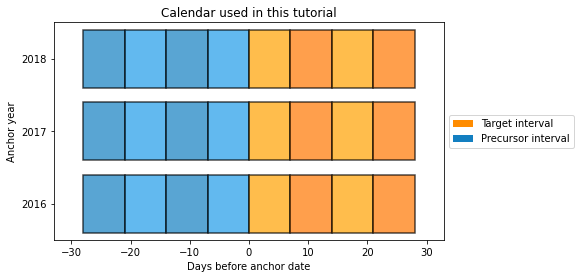

In [119]:
cal = s2spy.time.Calendar(anchor="08-01")
cal.add_intervals("target", length="1W", n=4)
cal.add_intervals("precursor", length="1W", n=4)

cal = cal.map_to_data(field)
cal.visualize(n_years=3, relative_dates=True)
_ = plt.title("Calendar used in this tutorial")

Resample data with calendar.

In [120]:
field_resampled: xr.Dataset = s2spy.time.resample(cal, field)
target_resampled: xr.Dataset = s2spy.time.resample(cal, target)

In [116]:
field_resampled

<xarray.Dataset>
Dimensions:      (anchor_year: 63, i_interval: 8, latitude: 91, longitude: 180,
                  bounds: 2)
Coordinates:
  * anchor_year  (anchor_year) int64 2021 2020 2019 2018 ... 1962 1961 1960 1959
  * i_interval   (i_interval) int64 -4 -3 -2 -1 1 2 3 4
  * latitude     (latitude) float64 90.0 88.0 86.0 84.0 ... -86.0 -88.0 -90.0
  * longitude    (longitude) float64 -180.0 -178.0 -176.0 ... 174.0 176.0 178.0
    interval     (anchor_year, i_interval, bounds) datetime64[ns] 2021-07-04 ...
    target       (i_interval) bool False False False False True True True True
Dimensions without coordinates: bounds
Data variables:
    sst          (anchor_year, i_interval, latitude, longitude) float64 271.5...

Text(0.5, 1.0, 'DBSCAN')

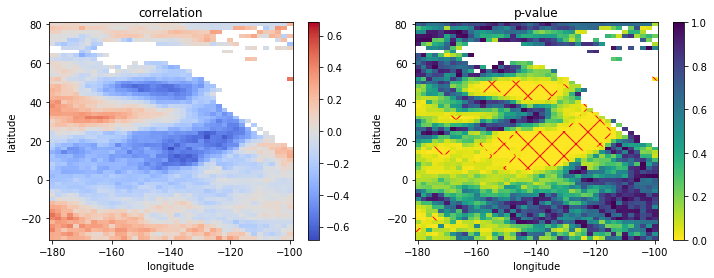

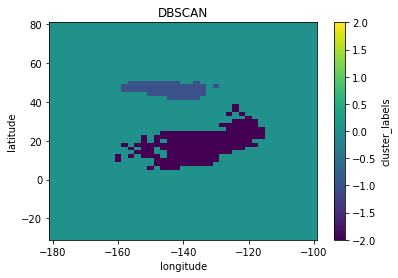

In [88]:
target_timeseries = target_resampled.sel(cluster=3)["ts"]
precursor_field = field_resampled["sst"]

target_intervals = 1
lag = 4
alpha = 0.01
eps_km = 600
min_area_km2 = 600**2

rgdr = RGDR(
    target_intervals=target_intervals,
    lag=lag,
    eps_km=eps_km,
    alpha=alpha,
    min_area_km2=min_area_km2
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
_ = rgdr.preview_correlation(precursor_field, target_timeseries, ax1=ax1, ax2=ax2)

fig, ax = plt.subplots(figsize=(6, 4))
RGDR(
    target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2
    ).preview_clusters(precursor_field, target_timeseries, ax=ax, vmin=-2, vmax=2)
ax.set_title('DBSCAN')

try HDBSCAN

In [89]:
corr, p_vals = rgdr.get_correlation(precursor_field, target_timeseries)
data = precursor_field.to_dataset()
data["corr"], data["p_val"] = corr, p_vals  # Will require less tracking of indices
data = data.stack(coord=["latitude", "longitude"])
coords = np.asarray(data["coord"].values.tolist())
coords = np.radians(coords)

We set min_cluster_size to 10, rather conservative.

In [99]:
labels = np.zeros(len(coords), dtype=int)

clusterers = []
for sign, sign_mask in zip([1, -1], [data["corr"] >= 0, data["corr"] < 0]):
    mask = np.logical_and(data["p_val"] < 0.01, sign_mask)

    if np.sum(mask) > 0:  # Check if the mask contains any points to cluster
        clusterer = hdbscan.HDBSCAN(min_cluster_size = 10, metric='haversine')
        clusterers.append(clusterer)
        db = clusterer.fit(coords[mask]) #noisy samples are -1
        labels[mask] = sign * (db.labels_ + 1)

Text(0.5, 1.0, 'HDBSCAN')

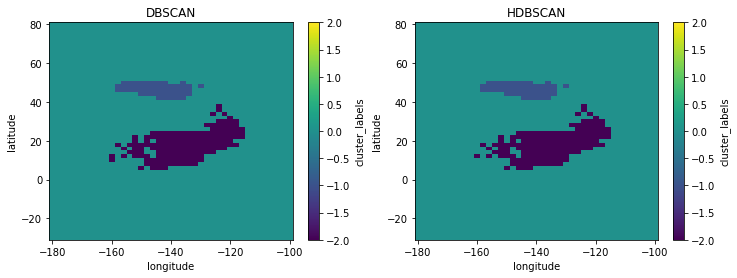

In [101]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

#HDBSCAN
precursor = precursor_field.stack(coord=["latitude", "longitude"])
precursor["cluster_labels"] = ("coord", labels)
precursor["cluster_labels"] = precursor["cluster_labels"].astype("int16")
precursor = precursor.unstack(("coord"))
precursor["cluster_labels"].plot(cmap="viridis", ax=ax2, vmin=-2, vmax=2)
#DBSCAN
RGDR(
    target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2
    ).preview_clusters(precursor_field, target_timeseries, ax=ax1, vmin=-2, vmax=2)

ax1.set_title('DBSCAN')
ax2.set_title('HDBSCAN')

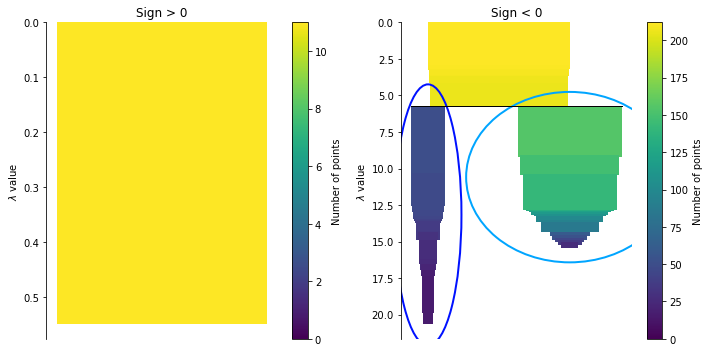

In [102]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
clusterers[0].condensed_tree_.plot(select_clusters=True,
                               selection_palette=plt.cm.jet(np.linspace(0, 1, 8))[1:-1], cmap='viridis', colorbar=True, axis=ax1)
clusterers[1].condensed_tree_.plot(select_clusters=True,
                               selection_palette=plt.cm.jet(np.linspace(0, 1, 8))[1:-1], cmap='viridis', colorbar=True, axis=ax2)
ax1.set_title('Sign > 0')
ax2.set_title('Sign < 0')
fig.tight_layout()

Now we have the same result! It depends on tuning the min_cluster_size parameter.

This result is still not satisfactory though: we have no positive clusters in our set,
while the gradient between the negative cluster and the positive cluster might be
a very important physical aspect that our model needs to learn.

In [151]:
labels = np.zeros(len(coords), dtype=int)

clusterers = []
for sign, sign_mask in zip([1, -1], [data["corr"] >= 0, data["corr"] < 0]):
    mask = np.logical_and(data["p_val"] < 0.01, sign_mask)

    if np.sum(mask) > 0:  # Check if the mask contains any points to cluster
        clusterer = hdbscan.HDBSCAN(min_cluster_size = 4, metric='haversine')
        clusterers.append(clusterer)
        db = clusterer.fit(coords[mask]) #noisy samples are -1
        labels[mask] = sign * (db.labels_ + 1)

Text(0.5, 1.0, 'HDBSCAN')

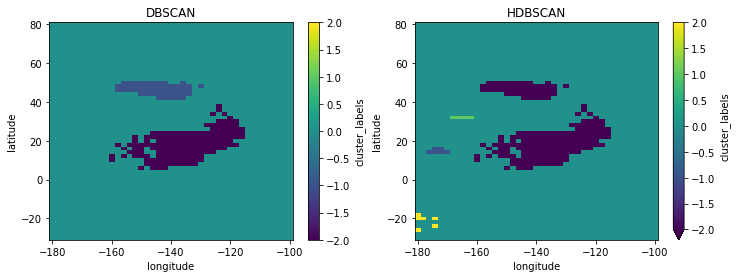

In [152]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

#HDBSCAN
precursor = precursor_field.stack(coord=["latitude", "longitude"])
precursor["cluster_labels"] = ("coord", labels)
precursor["cluster_labels"] = precursor["cluster_labels"].astype("int16")
precursor = precursor.unstack(("coord"))
precursor["cluster_labels"].plot(cmap="viridis", ax=ax2, vmin=-2, vmax=2)
#DBSCAN
RGDR(
    target_intervals, lag, eps_km=eps_km, alpha=alpha, min_area_km2=min_area_km2
    ).preview_clusters(precursor_field, target_timeseries, ax=ax1, vmin=-2, vmax=2)

ax1.set_title('DBSCAN')
ax2.set_title('HDBSCAN')

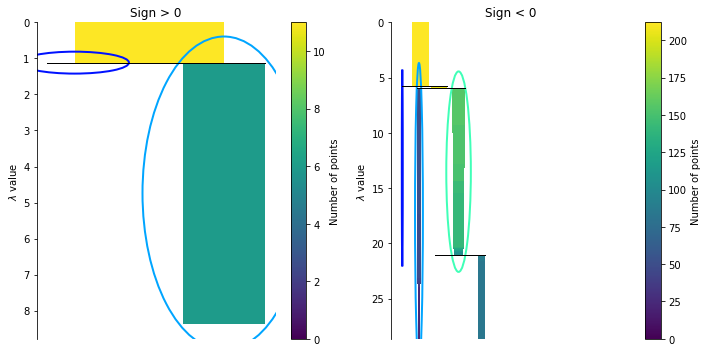

In [153]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
clusterers[0].condensed_tree_.plot(select_clusters=True,
                               selection_palette=plt.cm.jet(np.linspace(0, 1, 8))[1:-1], cmap='viridis', colorbar=True, axis=ax1)
clusterers[1].condensed_tree_.plot(select_clusters=True,
                               selection_palette=plt.cm.jet(np.linspace(0, 1, 8))[1:-1], cmap='viridis', colorbar=True, axis=ax2)
ax1.set_title('Sign > 0')
ax2.set_title('Sign < 0')
fig.tight_layout()

### Test speed
Let's test the speed of DBSCAN vs HDBSCAN on the last dataset

In [186]:
import time

runs = np.arange(1,101)
runtimes_DBSCAN = []

min_samples = np.arange(1,21)

#DBSCAN
for j in min_samples:
        runtimes_DBSCAN_j = []
        labels = np.zeros(len(coords), dtype=int)
        for i in runs:
                start = time.time()
                clusterers = []
                for sign, sign_mask in zip([1, -1], [data["corr"] >= 0, data["corr"] < 0]):
                        mask = np.logical_and(data["p_val"] < 0.01, sign_mask)
                        if np.sum(mask) > 0:  # Check if the mask contains any points to cluster
                                clusterer = DBSCAN(
                                        eps=eps_km / 6371,
                                        min_samples=j,
                                        algorithm="auto",
                                        metric="haversine")
                                clusterers.append(clusterer)
                                db = clusterer.fit(coords[mask]) #noisy samples are -1
                                labels[mask] = sign * (db.labels_ + 1)
                end = time.time()
                total_time = end-start
                runtimes_DBSCAN_j.append(total_time)
        runtimes_DBSCAN.append(runtimes_DBSCAN_j)

#HDBSCAN
runtimes_HDBSCAN = []
for j in min_samples:
        runtimes_HDBSCAN_j = []
        labels = np.zeros(len(coords), dtype=int)
        for i in runs:
                start = time.time()
                clusterers = []
                for sign, sign_mask in zip([1, -1], [data["corr"] >= 0, data["corr"] < 0]):
                        mask = np.logical_and(data["p_val"] < 0.01, sign_mask)

                        if np.sum(mask) > 0:  # Check if the mask contains any points to cluster
                                clusterer = hdbscan.HDBSCAN(
                                        min_samples=j,
                                        metric='haversine'
                                        )
                                clusterers.append(clusterer)
                                db = clusterer.fit(coords[mask]) #noisy samples are -1
                                labels[mask] = sign * (db.labels_ + 1)
                end = time.time()
                total_time = end-start
                runtimes_HDBSCAN_j.append(total_time)
        runtimes_HDBSCAN.append(runtimes_HDBSCAN_j)


<AxesSubplot:>

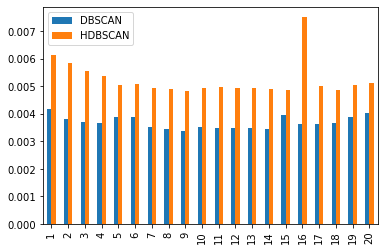

In [187]:
#pandas dataframe
df_DBSCAN = pd.DataFrame(runtimes_DBSCAN, index=min_samples, columns = runs)
df_HDBSCAN = pd.DataFrame(runtimes_HDBSCAN, index=min_samples, columns = runs)
d = {'DBSCAN': df_DBSCAN, 'HDBSCAN': df_HDBSCAN}
df = pd.concat(d.values(), axis=1, keys=d.keys())
df = df.transpose()
df.groupby(level=[0]).mean().transpose().plot(kind='bar')

Not really faster?